<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/AprendizadoMaquina/T%C3%B3pico%2002%20-%20Aprendizado%20Supervisionado/Dados%20Desbalanceados/T%C3%B3pico_02_Aprendizado_Supervisionado_Tratando_Dados_Desbalanceados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tutorial Tratando Dados Desbalanceados

Neste tutorial, vamos explorar o tema de conjuntos de dados desbalanceados, mas desta vez com foco em estratégias práticas para lidar com eles. Como foi discutido anteriormente, um conjunto de dados desbalanceado ocorre quando a distribuição de classes na amostra não é uniforme, o que pode levar a problemas de desempenho em modelos de aprendizado de máquina. Para lidar com esse problema, vamos examinar as principais estratégias para lidar com conjuntos de dados desbalanceados, incluindo oversampling, undersampling e técnicas de reponderação. Além disso, vamos discutir como avaliar a eficácia dessas técnicas e como escolher a abordagem correta para lidar com um conjunto de dados desbalanceado específico. Para isso, vamos utilizar a biblioteca [imbalanced-learn](https://https://imbalanced-learn.org/stable/), uma biblioteca Python que oferece uma ampla gama de técnicas de reamostragem para lidar com conjuntos de dados desbalanceados.

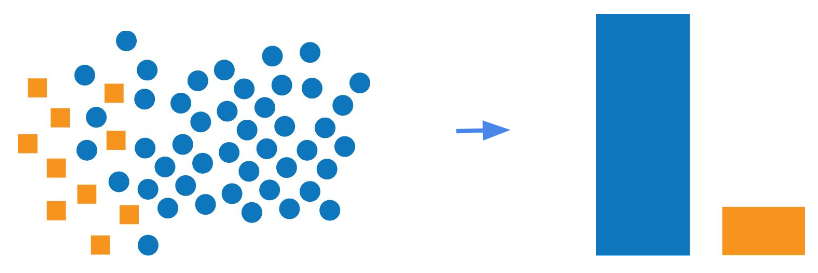

#Overfitting

O overfitting é um problema recorrente em modelos de aprendizado de máquina, que surge quando o modelo é treinado para se ajustar excessivamente aos dados de treinamento e, por isso, não consegue generalizar adequadamente para novos dados. Em particular, conjuntos de dados desbalanceados podem causar overfitting nos modelos, uma vez que eles podem não ser capazes de generalizar adequadamente todas as classes. 

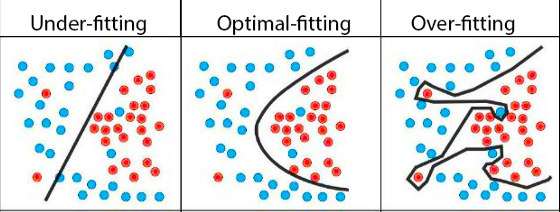

#Inicialização


*   Bibliotecas
*   Parâmetros Globais (Seed...)




In [1]:
#Datasets e Avaliação
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Modelos
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#Imblearn
from imblearn.pipeline import make_pipeline
from imblearn.base import BaseSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import (SMOTE, RandomOverSampler)
from imblearn.combine import SMOTEENN

#Auxialires
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


#Seed (Garante a reproducibilidade)
random_state = 9999

#Funções auxiliares



In [2]:
def plot_dataset(X,y,dataset_name='Dataset',print_info=True,print_class_dist=True,print_dataset_dist=True):

  #Converto para pandas dataframe para facilitar a manipulação
  df = pd.DataFrame(X, columns=['feature_1', 'feature_2', 'feature_3'])
  df['class'] = y

  if print_info:   
    print(f"##### Vetores de Características - {dataset_name} #####")    
    df.info()
    #Shuffle e mostra os primeiros 10 elementos
    print(df.sample(frac = 1).head(10))
    

  if print_class_dist:  
    print("#######################################")  
    # Criando o gráfico de barras com Matplotlib
    counts = df["class"].value_counts()
    plt.figure(figsize=(5,4))
    plt.bar(counts.index, counts.values,color=['red','green','blue'])

    # Adicionando um título e rótulos de eixo
    plt.xlabel("Classes")
    plt.xticks([0,1,2])
    plt.ylabel("#Amostras")
    plt.title(f'Distribuição das Classes - {dataset_name}')
    # Mostrando o gráfico
    plt.show()

  if print_dataset_dist: 
    print("#######################################")
    # Configurando o gráfico
    fig = plt.figure(figsize=(6,8))
    ax = fig.add_subplot(111, projection='3d')

    colors = df['class'].copy()
    colors[colors == 0] = 'red'
    colors[colors == 1] = 'green'
    colors[colors == 2] = 'blue'
    # Plotando os dados
    ax.scatter(df['feature_1'], df['feature_2'],df['feature_3'], c=colors)

    # Configurando as legendas dos eixos
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    plt.title(f'Distribuição das Amostras - {dataset_name}')
    # Mostrando o gráfico
    plt.show()
    print("#######################################")

In [3]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    counts = np.unique(y_res,return_counts=True)    
    return counts

In [4]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

#Avaliando taxa de desbalanceamento

Vamos ilustrar a influência da taxa de balanceamento. Avalie o impacto nas fronteiras de decisão, de acordo a diferença entre o número de amostras em cada classe. Voce pode testar em várias classificadores

In [8]:
model = GaussianNB()
#model = DecisionTreeClassifier()
#model = KNeighborsClassifier()

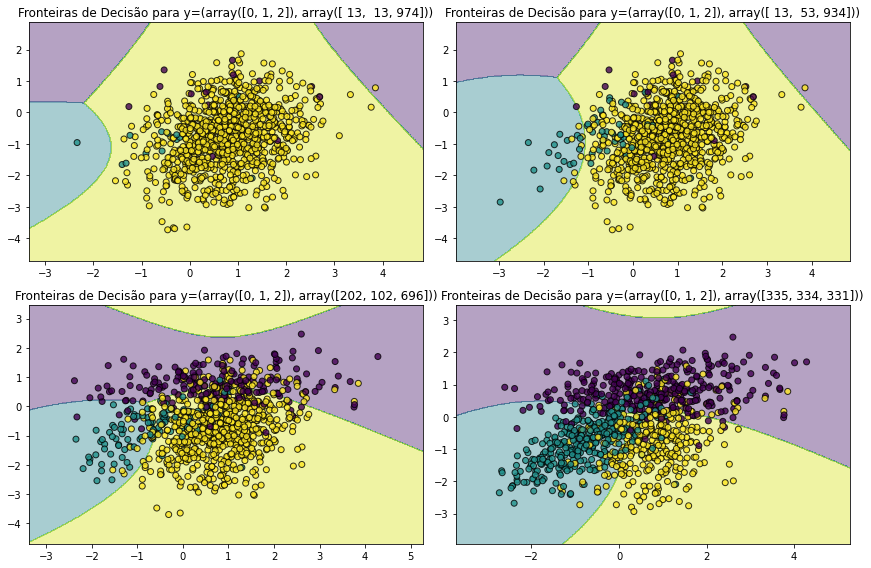

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

ax_arr = (ax1, ax2, ax3, ax4)
weights_arr = ((0.01, 0.01, 0.98), (0.01, 0.05, 0.94),
               (0.2, 0.1, 0.7), (0.33, 0.33, 0.33))
for ax, weights in zip(ax_arr, weights_arr):
    X, y = make_classification(n_samples=1000, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=3,
                               n_clusters_per_class=1,
                               weights=weights,
                               class_sep=0.8, random_state=random_state)
    model.fit(X, y)
    
    plot_decision_function(X, y, model, ax)
    counts = np.unique(y,return_counts=True)
    ax.set_title('Fronteiras de Decisão para y={}'.format(counts))
fig.tight_layout()

#Balanceamento dos dados

*   Redução de amostras (UnderSampling)
*   Aumento de amostras (Oversampling / Data Augmentation)
*   Combinação (Over/Under sampling)
  > * SMOOTE
  > * SMOOTENN



Primeiro, vamos gerar um dataset sintetico e analisar individualmente as amostras

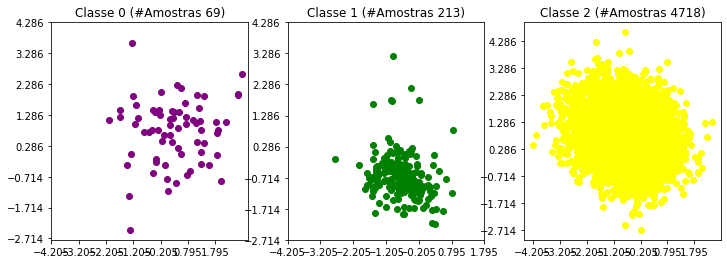

In [91]:
X, y = make_classification(n_samples=5000, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=3,
                               n_clusters_per_class=1,
                               weights=(0.01, 0.04, 0.95),
                               class_sep=0.8, random_state=random_state)

min_x,max_x=np.min(X[:,0]),np.max(X[:,0])
min_y,max_y=np.min(X[:,1]),np.max(X[:,1])
colors = ['purple','green','yellow']

#Distribuição individuais das classes
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in [0,1,2]:
  
  values = X[y == i]
  axs[i].scatter(values[:,0],values[:,1],color=colors[i])
  axs[i].set_xticks(np.arange(min_x,max_x, 1.0))
  axs[i].set_yticks(np.arange(min_y,max_y, 1.0))
  axs[i].set_title(f"Classe {i} (#Amostras {values.shape[0]})")

plt.show()

#Redução de amostras (UnderSampling)

  Reduz o número de exemplos das classes majoritárias afim equilibrar a distribuição de classes. A seleção é feita aletóriamente. A função RandomUnderSampler() implementa essa técnica.

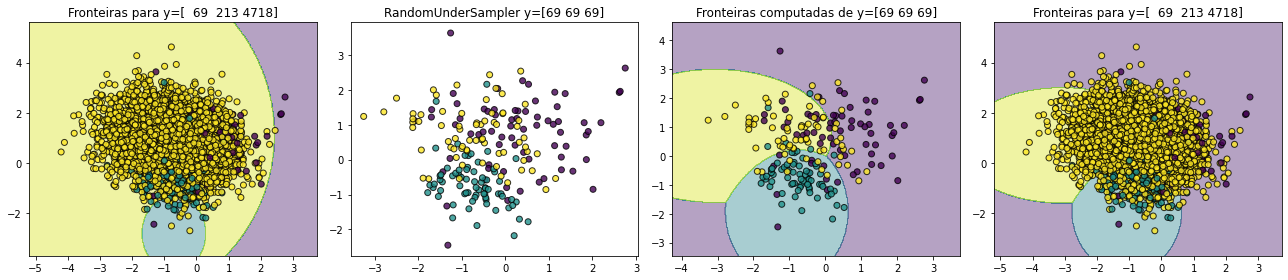

In [93]:
#Modelo treinado sobre classes desbalanceadas
model = GaussianNB()
model.fit(X, y)

#Fronteiras de decisao sobre classes desbalanceadas
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 4))
plot_decision_function(X, y, model, ax1)
counts = np.unique(y,return_counts=True)
ax1.set_title('Fronteiras para y={}'.format(counts[1]))

#UnderSampling
sampler = RandomUnderSampler(random_state=random_state)
X_bal, y_bal = sampler.fit_resample(X, y)
counts = np.unique(y_bal,return_counts=True)
#counts = plot_resampling(X, y, sampler, ax2)
ax2.scatter(X_bal[:,0],X_bal[:,1], c=y_bal, alpha=0.8, edgecolor='k')
ax2.set_title('RandomUnderSampler y={}'.format(counts[1]))

#Retreina com o sampler
model.fit(X_bal, y_bal)
plot_decision_function(X_bal, y_bal, model, ax3)
ax3.set_title('Fronteiras computadas de y={}'.format(counts[1]))

plot_decision_function(X, y, model, ax4)
counts = np.unique(y,return_counts=True)
ax4.set_title('Fronteiras para y={}'.format(counts[1]))
fig.tight_layout()
plt.show()

fig.tight_layout()
plt.show()

Analisandos as fronteiras de decisão, é fácil perceber que o modelo não generaliza bem as classes 0 (roxo) e 1 (verde), dado que a classe 3 (amarela) é a majoritária.

Ao aplicar a redução de amostras, as fronteiras são redefinidas, mas no entanto, percebemos que ainda existirá zonas de confusão.

#Aumento de amostras (Oversampling / Data Augmentation)